# Distance trajectory under climate change：a study on AUS-NEM


From data in Australia National Electricity Market (2011-2020), this code aims to 
(1) extract historical data for the modified IEEE 24 model, whereby empirical distribution can be obtained;
(2) estimate 2-Wasserstein distance discribing envolutionary changes;


Methods in [1] were adopted, whose source code can be found in [2]. Besides, data in 'df_n','df_g' were also downloaded from [2].<br/>
This version was updated in Dec., 2020.




### Data preparation for IEEE RTS 24-node model embeding Australia NEM data [3],[4]: ####

In total, the NEM generator dataset contains technical and economic information relating to 203 generating units （conventional generators and renewable energy units, each has a dispatchable unit ID）, while the network dataset consists of 912 nodes, and 1406 AC edges with line voltages in the range of 110 kV to 500 kV.
There are ***5*** trading regions (NSW,QLD,SA,TAS,VIC) and ***16*** NEM zones in the operation devided by AEMO. To facilitate our transmission network planning study, We take this 16-node model by assuming that the power balance constriants are met in each NEM zone.Therefore, the load and wind power signals are aggragated in these 16 nodes based on their geographic positions.

In the original IEEE RTS 24-node model, it has 17 load nodes while no wind power. <br/>
In the modified IEEE RTS 24-node model, technical and economic information relating to generators and topology of existing lines are not changed. However, ***to be compatible with the NEM dataset***: <br/> (1) load demand at #13 node (reference node) is set to be zero (so that we get a 16-load model);  <br/> (2) #11,#12,#17,#24 are selected as nodes equipped with wind power units.  


### Basic procedures ###
***Step 1***: Read data and data standarization: Get the standard version of variable injections durting 2011-2020, $P_v=[P_D;P_W]$  denoted as $z$;<br/> 
***Step 2***: Gaussian mixture model (GMM) selection: estimate the best number of componets and covraince distance of GMM model<br/> 
***Step 3***: Fit  distributions of $z$ as GMM;<br/> 
***Step 4***: Calculate  2-Wasserstein distances between several 5-year-step GMM pairs, including [2011 v.s. 2016], [2012 v.s. 2017],  [2013 v.s. 2018], [2014 v.s. 2019], [2015 v.s. 2020]. Therefore, envolutionary changes over five years can be described.<br/> 
***Step 5***:Summary and final results 
    

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans

import scipy.io as sio
from pyomo.environ import *
import matplotlib.pyplot as plt

from random import random
from scipy.stats import multivariate_normal
from scipy.stats import matrix_normal

import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sps
import scipy.linalg as spl
from scipy.optimize import linprog

import ot
from sklearn import preprocessing


##  Paths to directories

In [2]:
# Core data directory (common files)
data_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data'))

# MMSDM data directory
MMSDMdata_dir = os.path.join(data_dir,'AUS2011_2020')

# Network directory
network_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '1_network'))

# Generators directory
gens_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '2_generators'))

# Output directory
output_dir = os.path.abspath(os.path.join(os.path.curdir, 'output'))
output_for_mat_dir=os.path.abspath(os.path.join(os.path.curdir, 'output_for_mat'))

# basic DataFrame for network (index=NODE_ID)
df_n = pd.read_csv(os.path.join(network_dir, 'output', 'network_nodes.csv'), index_col='NODE_ID', dtype={'NEAREST_NODE':np.int32})

# basic DataFrame for generator (index=DUID)
df_g = pd.read_csv(os.path.join(gens_dir, 'output', 'generators.csv'), dtype={'NODE': int}, index_col='DUID')

# population information 


## Duration of the dataset

In [3]:
month_list=['0101','0201','0301','0401','0501','0601','0701','0801','0901','1001','1101','1201']

year_list1=['2011']
year_list2=['2012','2013','2014','2015','2016','2017','2018','2019','2020']
Allyears=year_list1+year_list2

Missing_list=['20090101','20090201','20090301','20090401','20090501','20090601','20150601','20160101','20170701','20170801','20170901','20200601','20200701','20201201']

## Step 1 : Read data and data standarization

#### Function to get dispatch data of wind power
1. Every dispatched units have an ID (i.e., DUID) while we attached the fuel type from 'df_g', so that wind power dispatch data can be extracted;
2. Parse and save unit dispatch data. Note that dispatch in MW is given at 5min intervals, and that the time resolution of demand data is 30min intervals, corresponding to the length of a trading period in the NEM. To align the time resolution of these signals unit dispatch data are aggregated, with mean power output over 60min intervals computed for each DUID.


In [4]:
def Standardization(df_population):
    L=np.linalg.cholesky(df_population.cov().values)
    invL=np.linalg.inv(L)
    
    Zsample=np.dot(invL,(df_population-df_population.mean()).values.T)
    df_z=pd.DataFrame(Zsample).T

    return df_z

In [5]:
# Get the four wind power data
def get_zonal_wind_power (df_DISPATCH_UNIT_SCADA):
    # Convert to datetime objects
    df_DISPATCH_UNIT_SCADA['SETTLEMENTDATE'] = pd.to_datetime(df_DISPATCH_UNIT_SCADA['SETTLEMENTDATE'])
    # Pivot dataframe. Dates are the index values, columns are DUIDs, values are DUID dispatch levels
    df_DISPATCH_UNIT_SCADA_piv = df_DISPATCH_UNIT_SCADA.pivot(index='SETTLEMENTDATE', columns='DUID', values='SCADAVALUE')
    # To ensure the 30th minute interval is included during each trading interval the time index is offset
    # by 1min. Once the groupby operation is performed this offset is removed.
    df_DISPATCH_UNIT_SCADA_agg = df_DISPATCH_UNIT_SCADA_piv.groupby(pd.Grouper(freq='60Min', base=1, label='right')).mean()
    df_DISPATCH_UNIT_SCADA_agg = df_DISPATCH_UNIT_SCADA_agg.set_index(df_DISPATCH_UNIT_SCADA_agg.index - pd.Timedelta(minutes=1))
    df_DISPATCH_UNIT_SCADA_agg
    # (1)Nodal renewable energy system (RES) disaptch;(2)NEM Zonal RES dispatch
    # Add fuel category to each DUID in SCADA dispatch dataframe
    df_DISPATCH_UNIT_SCADA_agg = df_DISPATCH_UNIT_SCADA_agg.T.join(df_g[['FUEL_CAT']])
    # Only consider intermittent solar and wind generators
    mask = df_DISPATCH_UNIT_SCADA_agg['FUEL_CAT'].isin(['Wind'])
    # Keep wind and solar (RES) DUIDs, drop fuel category column, and transpose (columns=DUID, index=Timestamp)
    # All intermittent generation profiles
    # (columns=DUID, index=Timestamps)
    df_DUID_RES = df_DISPATCH_UNIT_SCADA_agg[mask].drop('FUEL_CAT', axis=1).T  

    #(1) Nodal RES
    # Add node to which generator is connected, groupby node and sum, 
    # reindex columns using all node IDs, yielding total intermittent injection at each node
    # Injections from intermittent sources (columns=node ID, index=Timestamps)
    df_nodal_RES=df_DUID_RES.T.join(df_g[['NODE']], how='left').groupby('NODE').sum().T.reindex(columns=df_n.index, fill_value=0)

    df_regional_RES=df_nodal_RES.T.join(df_n[['NEM_REGION']], how='left').groupby('NEM_REGION').sum().T.reindex(columns=df_n['NEM_REGION'].unique(), fill_value=0)

    #(2)Zonal RES
    #Fixed injections from intermittent sources for each NEM zone (columns=Zone ID, index=Timestamps
    df_zonal_RES=df_nodal_RES.T.join(df_n[['NEM_ZONE']], how='left').groupby('NEM_ZONE').sum().T.reindex(columns=df_n['NEM_ZONE'].unique(), fill_value=0)
    
    #(3) return the selected RESs for IEEE 24 model
    df_wind=df_zonal_RES[['NSA']]
    return df_wind

#### Function to get variable injections in one year
 Load data in each NEM region are given at 30min intervals. Likewise, demand data are aggregated, with mean values over 60min intervals computed for each region. <br />



In [6]:
def get_STDdata_oneYear(year):
        df_Pv=pd.DataFrame()
        df_load_5Region=pd.DataFrame()
        df_wind=pd.DataFrame(columns = ['NSA']) 
        
        for month in month_list:
            a=year+''+month
            if a in Missing_list:
                continue
            print(a)    
            #-------Load data-----------------
            name_csv='PUBLIC_DVD_TRADINGREGIONSUM_201901010000.CSV'
            name_csv=name_csv.replace('0101',month)
            name_csv=name_csv.replace('2019',year)
            # Regional summary for each trading interval
            df_TRADINGREGIONSUM = pd.read_csv(os.path.join(MMSDMdata_dir, name_csv),
                                              skiprows=1, skipfooter=1, engine='python')
            # Convert settlement date to datetime
            df_TRADINGREGIONSUM['SETTLEMENTDATE'] = pd.to_datetime(df_TRADINGREGIONSUM['SETTLEMENTDATE'])
            # Pivot dataframe. Index is timestamp, columns are NEM region IDs, values are total demand
            df_TRADINGREGIONSUM_piv = df_TRADINGREGIONSUM.pivot(index='SETTLEMENTDATE', columns='REGIONID', values='TOTALDEMAND')
            df_TRADINGREGIONSUM_piv = df_TRADINGREGIONSUM_piv.groupby(pd.Grouper(freq='60Min', base=1, label='right')).mean()
            df_TRADINGREGIONSUM_piv = df_TRADINGREGIONSUM_piv.set_index(df_TRADINGREGIONSUM_piv.index - pd.Timedelta(minutes=1))
            
            df_load_5Region=df_load_5Region.append(df_TRADINGREGIONSUM_piv)
            
            #-------Wind data-----------------
            name_csv='PUBLIC_DVD_DISPATCH_UNIT_SCADA_201901010000.CSV'
            name_csv=name_csv.replace('0101',month)
            name_csv=name_csv.replace('2019',year)
        
            df_DISPATCH_UNIT_SCADA = pd.read_csv(os.path.join(MMSDMdata_dir, name_csv),
                                         skiprows=1, skipfooter=1, engine='python')
    
            df_wind0=get_zonal_wind_power (df_DISPATCH_UNIT_SCADA)            
            df_wind=df_wind.append(df_wind0)
        

        #-------Variable injections--------
        df_Pv = pd.concat([df_load_5Region, df_wind], axis=1)
            
        # Standardization
        df_z=Standardization(df_Pv)
                    
        return  df_z

In [7]:
DataSet={}

for year in Allyears:
    df_z1=get_STDdata_oneYear(year)
    DataSet[year]=df_z1
    

20110101
20110201
20110301
20110401
20110501
20110601
20110701
20110801
20110901
20111001
20111101
20111201
20120101
20120201
20120301
20120401
20120501
20120601
20120701
20120801
20120901
20121001
20121101
20121201
20130101
20130201
20130301
20130401
20130501
20130601
20130701
20130801
20130901
20131001
20131101
20131201
20140101
20140201
20140301
20140401
20140501
20140601
20140701
20140801
20140901
20141001
20141101
20141201
20150101
20150201
20150301
20150401
20150501
20150701
20150801
20150901
20151001
20151101
20151201
20160201
20160301
20160401
20160501
20160601
20160701
20160801
20160901
20161001
20161101
20161201
20170101
20170201
20170301
20170401
20170501
20170601
20171001
20171101
20171201
20180101
20180201
20180301
20180401
20180501
20180601
20180701
20180801
20180901
20181001
20181101
20181201
20190101
20190201
20190301
20190401
20190501
20190601
20190701
20190801
20190901
20191001
20191101
20191201
20200101
20200201
20200301
20200401
20200501
20200801
20200901
20201001
2

## Step 2: GMM Selection 

## ----Estimate the best number of components, and best covariance type for the GMM model


#### Note that, in this analysis:####
 
 (1) Alothough a 16-node load vector is considered, we estimate the Wasserstein distance using the load data aggregated at the five trading regions, since the detialed load data at each node are not avialiable;<br />
 (2) Although a 4-node wind power vector is considered, we estimate the Wasserstein distance using data at site "NSA", since wind power at the remaining sites are negligible in early years, say, the year of 2011;<br />
 (3)  BIC based GMM selection  [5] is adopted




In [8]:
def get_BIC(X):
    '''Covariance types:
'full' (each component has its own general covariance matrix),
'tied' (all components share the same general covariance matrix),
'diag' (each component has its own diagonal covariance matrix),
'spherical' (each component has its own single variance).'''
    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 26)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return (bic,best_gmm)

In [9]:
df_bestGMM=pd.DataFrame(data=np.zeros((10,2)), index=year_list1+year_list2,columns=['Best number of components','Covariance Type'])
for year in Allyears:
    X=DataSet[year]
    bic,best_gmm=get_BIC(X)
    df_bestGMM.loc[year,'Best number of components']=best_gmm.n_components
    df_bestGMM.loc[year,'Covariance Type']=best_gmm.covariance_type

In [10]:
df_bestGMM

,Best number of components,Covariance Type
2011,20.0,full
2012,20.0,full
2013,22.0,full
2014,19.0,full
2015,23.0,full
2016,23.0,full
2017,14.0,full
2018,21.0,full
2019,16.0,full
2020,14.0,full


## Step 3: Fit GMM model to data
## (with components number=6, covariance type=full)

In [11]:
# function for fitting
def GMM_fit(df_population, n_components):
    # Fit the GMM and save the GMM parameters as distionary and mat. file
    clf = mixture.GaussianMixture(n_components, covariance_type='full')
    clf.fit(df_population)

    GMM={}
    GMM['Pr']=clf.weights_# Pr for each components
    GMM['means']=clf.means_
    GMM['Covariances']=clf.covariances_
    return GMM

#### The following codes are downloaded from [6]: Wasserstein-type distance betwwen two GMMs

In [12]:
# Wasserstein distance betwwen two Guassians
def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

In [13]:
# Wasserstein-type distance betwwen two GMMs
def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMMs
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return distGW2

## Step 4: Calculate  2-Wasserstein distances
#### Main function for fitting GMM and calculating distance

In [14]:
y1=year_list1[0]
y1

'2011'

In [15]:
distGMM_set = pd.DataFrame({'Year 1': 2011, 'Year 2': np.arange(2012, 2021)})

j=0
while j<=9:
    flag=True
    distGMM_0=np.zeros((9,1))
    
    y1=year_list1[0]
    df_z1=DataSet[y1]
    n_com1=int(df_bestGMM.loc[y1,'Best number of components'])
    GMM_z1=GMM_fit(df_z1,n_com1)
    pi0=GMM_z1['Pr']
    mu0=GMM_z1['means']
    S0=GMM_z1['Covariances']
    
    for i in range(0,9):
            
            y2=year_list2[i]                       
            df_z2=DataSet[y2]
            n_com2=int(df_bestGMM.loc[y2,'Best number of components'])
            GMM_z2=GMM_fit(df_z2,n_com2)                   
            pi1=GMM_z2['Pr']            
            mu1=GMM_z2['means']                    
            S1=GMM_z2['Covariances']        

            distGW2=GW2(pi0,pi1,mu0,mu1,S0,S1)
            if distGW2==0:
                print('break this round')
                flag=False
                break
            else:
                distGMM_0[i]=sqrt(distGW2)
                
    if not flag: 
        continue # when flag==False, j==j
    else:
        distGMM_set['Test_'+str(j+1)]=distGMM_0
        j+=1
                
                
    print(distGMM_set)
        

   Year 1  Year 2    Test_1
0    2011    2012  1.300515
1    2011    2013  1.364861
2    2011    2014  1.374256
3    2011    2015  1.421504
4    2011    2016  1.468524
5    2011    2017  1.509088
6    2011    2018  1.473344
7    2011    2019  1.489651
8    2011    2020  1.645252
   Year 1  Year 2    Test_1    Test_2
0    2011    2012  1.300515  1.377600
1    2011    2013  1.364861  1.393549
2    2011    2014  1.374256  1.417758
3    2011    2015  1.421504  1.325344
4    2011    2016  1.468524  1.544812
5    2011    2017  1.509088  1.492930
6    2011    2018  1.473344  1.479238
7    2011    2019  1.489651  1.545170
8    2011    2020  1.645252  1.633612
   Year 1  Year 2    Test_1    Test_2    Test_3
0    2011    2012  1.300515  1.377600  1.348405
1    2011    2013  1.364861  1.393549  1.313458
2    2011    2014  1.374256  1.417758  1.370281
3    2011    2015  1.421504  1.325344  1.358144
4    2011    2016  1.468524  1.544812  1.474756
5    2011    2017  1.509088  1.492930  1.582367
6   

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ot/lp/__init__.py:276: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


break this round
   Year 1  Year 2    Test_1    Test_2    Test_3    Test_4    Test_5    Test_6  \
0    2011    2012  1.300515  1.377600  1.348405  1.348706  1.365116  1.405180   
1    2011    2013  1.364861  1.393549  1.313458  1.330814  1.404083  1.403415   
2    2011    2014  1.374256  1.417758  1.370281  1.308643  1.417924  1.397421   
3    2011    2015  1.421504  1.325344  1.358144  1.305332  1.374197  1.385730   
4    2011    2016  1.468524  1.544812  1.474756  1.454700  1.494614  1.527016   
5    2011    2017  1.509088  1.492930  1.582367  1.491596  1.535405  1.503644   
6    2011    2018  1.473344  1.479238  1.461328  1.372459  1.497508  1.482875   
7    2011    2019  1.489651  1.545170  1.454351  1.411149  1.515812  1.519994   
8    2011    2020  1.645252  1.633612  1.670470  1.626339  1.643198  1.618130   

     Test_7    Test_8    Test_9   Test_10  
0  1.351843  1.337478  1.293110  1.300946  
1  1.315621  1.310767  1.351783  1.367480  
2  1.314510  1.306414  1.410366  1.39011

## Step 5: Summary and final results

In [16]:
distGMM_set

,Year 1,Year 2,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_10
0,2011,2012,1.300515,1.377600,1.348405,1.348706,1.365116,1.405180,1.351843,1.337478,1.293110,1.300946
1,2011,2013,1.364861,1.393549,1.313458,1.330814,1.404083,1.403415,1.315621,1.310767,1.351783,1.367480
2,2011,2014,1.374256,1.417758,1.370281,1.308643,1.417924,1.397421,1.314510,1.306414,1.410366,1.390117
3,2011,2015,1.421504,1.325344,1.358144,1.305332,1.374197,1.385730,1.329922,1.357531,1.398310,1.349077
4,2011,2016,1.468524,1.544812,1.474756,1.454700,1.494614,1.527016,1.493770,1.449471,1.468733,1.455361
5,2011,2017,1.509088,1.492930,1.582367,1.491596,1.535405,1.503644,1.554836,1.473945,1.576075,1.479366
6,2011,2018,1.473344,1.479238,1.461328,1.372459,1.497508,1.482875,1.407778,1.428745,1.503004,1.416778
7,2011,2019,1.489651,1.545170,1.454351,1.411149,1.515812,1.519994,1.469846,1.492994,1.510667,1.480181
8,2011,2020,1.645252,1.633612,1.670470,1.626339,1.643198,1.618130,1.602139,1.612396,1.678796,1.646859


In [17]:
df_distGMM_mean= pd.DataFrame({'Year 1': 2011, 'Year 2': np.arange(2012, 2021)})
df_distGMM_mean['Average results over 10 tests']=distGMM_set.iloc[:,2:13].mean(axis=1)
df_distGMM_mean

,Year 1,Year 2,Average results over 10 tests
0,2011,2012,1.342890
1,2011,2013,1.355583
2,2011,2014,1.370769
3,2011,2015,1.360509
4,2011,2016,1.483176
5,2011,2017,1.519925
6,2011,2018,1.452306
7,2011,2019,1.488982
8,2011,2020,1.637719


Text(0.5, 0, ' Year')

Text(0, 0.5, 'Estimtated   $d$ ')

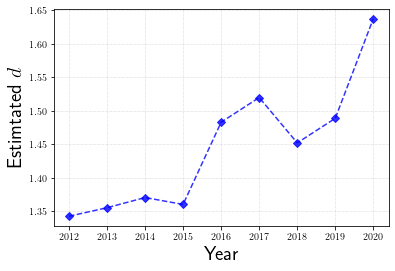

In [27]:
rc_fonts = {
    "text.usetex": True,
    'text.latex.preview': True, # Gives correct legend alignment.
    'mathtext.default': 'regular',
    'text.latex.preamble': [r"""\usepackage{bm}"""],
}
mpl.rcParams.update(rc_fonts)
font1= {'family' : 'Times New Roman', 'size':20}


x = np.arange(2012,2021) 
y = df_distGMM_mean['Average results over 10 tests']
plt.xlabel(" Year",font1) 
plt.ylabel("Estimtated   $d$ ",font1) 
plt.plot(x,y,'bD--',alpha=0.8) 

plt.grid(linestyle=':',linewidth=0.5,axis='both')


plt.savefig(os.path.join(output_for_mat_dir,"dFrom2011.png"),bbox_inches = 'tight')
plt.show()

# References
[1] -Xenophon, A., Hill, D. Open grid model of Australia’s National Electricity Market allowing backtesting against historic data. Sci Data 5, 180203 (2018). https://doi.org/10.1038/sdata.2018.203

[2] -Xenophon, A. K. Geospatial Modelling of Australia’s National Electricity Market. GitHub https://github.com/akxen/egrimod-nem (2018).

[3] -Australian Energy Markets Operator. Data Archive (2018). at http://www.nemweb.com.au/#mms-data-model  and https://visualisations.aemo.com.au/aemo/nemweb/index.html#mms-data-model

[4] -Australian Energy Markets Operator. Data Archive (2018). at https://nemweb.com.au/Data_Archive/Wholesale_Electricity/MMSDM/

[5] Gaussian Mixture Model Selection, https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

[6] Delon, Desolneux, A Wasserstein-type distance in the space of Gaussian Mixture Models, 2019,  https://github.com/judelo/gmmot




#  Datasets List from MMSDM
A summary of the tables used from AEMO's MMSDM database [3] is given below:

| Table | Description |
| :----- | :----- |
|DISPATCH_UNIT_SCADA | MW dispatch at 5 minute (dispatch) intervals for DUIDs within the NEM.|
|TRADINGREGIONSUM | Contains load in each NEM region at 30 minute (trading) intervals.|